# Tutorial: fitting a BL Lac broad-band SED using angpy and Gammapy

In order to perform a fit of the broad-band SED of a jetted AGN, `agnpy` includes a `Gammapy` wrapper.
A [Gammapy's `SpectralModel`](https://docs.gammapy.org/0.20/api/gammapy.modeling.models.SpectralModel.html) representing several radiative processes can be defined, and used either to fit flux points or to perform a forward-folding likelihood fit (if the instrument response is available in a format compatible with `Gammapy`). 

Several combination of radiative processes can be used to model the broad-band emission of a jetted AGN. For simplicity, we provide wrappers for the two scenarios most-commonly considered:
* `SycnhrotronSelfComptonSpectralModel`, representing the sum of synchrotron and synchrotron self-Compton radiation. This scenario is commonly considered to model BL Lac sources.
* `ExternalComptonSpectralModel`, representing the sum of synchrotron and synchrotron self-Compton radiation along with an external Compton component that can be computed over a list of targets. This scenario is commonly considered to model flat spectrum radio quasars.


In this tutorial we will show how to use the `SynchrotronSelfComptonSpectralModel` to fit the broad-band SED of Mrk 421, measured by a MWL campaign in 2009 [(Abdo et al. 2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...736..131A/abstract).

[gammapy](https://gammapy.org/) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import pkg_resources
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.constants import c
from astropy.table import Table
from astropy.coordinates import Distance
import matplotlib.pyplot as plt

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.wrappers import SynchrotronSelfComptonSpectralModel
from agnpy.wrappers import add_systematic_errors_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label

# import gammapy classes
from gammapy.modeling.models import SPECTRAL_MODEL_REGISTRY, SkyModel
from gammapy.estimators import FluxPoints
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit

# IMPORTANT: add the new custom model to the registry of spectral models recognised by gammapy
SPECTRAL_MODEL_REGISTRY.append(SynchrotronSelfComptonSpectralModel)

### `gammapy` wrapper of agnpy synchrotron and SSC
The `SynchrotronSelfComptonSpectralModel` wraps the `agnpy` functions to compute synchrotron and SSC radiation and returns a `Gammapy` `SpectralModel`. To initialise this spectral model, only the electron distribution has to be specified, the remaining parameters (the ones of the blob) will be initialised internally and can be modified at a later stage.

In [2]:
# electron energy distribution
n_e = BrokenPowerLaw(
    k_e=1e-8 * u.Unit("cm-3"),
    p1=2.02,
    p2=3.43,
    gamma_b=1e5,
    gamma_min=500,
    gamma_max=1e6,
)

# initialise the Gammapy SpectralModel
ssc_model = SynchrotronSelfComptonSpectralModel(n_e)

We can display all the parameters of the model at once

In [3]:
ssc_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str4,int64,float64,float64,bool,bool,str1
spectral,k_e,1.0000e-08,cm-3,0.000e+00,1.000e-10,1.000e+02,False,False,
spectral,p1,2.0200e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.4300e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,gamma_b,1.0000e+05,,0.000e+00,1.000e+02,1.000e+06,False,False,
spectral,gamma_min,5.0000e+02,,0.000e+00,1.000e+00,1.000e+03,True,False,
spectral,gamma_max,1.0000e+06,,0.000e+00,1.000e+05,1.000e+08,True,False,
spectral,z,1.0000e-01,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.0000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,B,1.0000e-01,G,0.000e+00,1.000e-04,1.000e+02,False,False,


or display separately the parameters related to the electrons energy distribution

In [4]:
ssc_model.spectral_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str4,int64,float64,float64,bool,bool,str1
spectral,k_e,1.0000e-08,cm-3,0.000e+00,1.000e-10,1.000e+02,False,False,
spectral,p1,2.0200e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.4300e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,gamma_b,1.0000e+05,,0.000e+00,1.000e+02,1.000e+06,False,False,
spectral,gamma_min,5.0000e+02,,0.000e+00,1.000e+00,1.000e+03,True,False,
spectral,gamma_max,1.0000e+06,,0.000e+00,1.000e+05,1.000e+08,True,False,


and the parameters related to the emission region, the blob in this case

In [5]:
ssc_model.emission_region_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str7,float64,str1,int64,float64,float64,bool,bool,str1
spectral,z,1.0000e-01,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.0000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,B,1.0000e-01,G,0.000e+00,1.000e-04,1.000e+02,False,False,
spectral,t_var,1.0000e+00,d,0.000e+00,1.000e-02,1.000e+02,True,False,


Let us set some reasonable initial parameters. For example, let us set the proper redshift for Mrk421 and some initial model parameters that will give our fit a decent starting point

In [6]:
ssc_model.parameters["z"].value = 0.0308
ssc_model.parameters["delta_D"].value = 18
ssc_model.parameters["B"].value = 0.05
ssc_model.parameters["gamma_b"].frozen = True

Let us check that they were correctly updated

In [7]:
ssc_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str4,int64,float64,float64,bool,bool,str1
spectral,k_e,1.0000e-08,cm-3,0.000e+00,1.000e-10,1.000e+02,False,False,
spectral,p1,2.0200e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.4300e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,gamma_b,1.0000e+05,,0.000e+00,1.000e+02,1.000e+06,True,False,
spectral,gamma_min,5.0000e+02,,0.000e+00,1.000e+00,1.000e+03,True,False,
spectral,gamma_max,1.0000e+06,,0.000e+00,1.000e+05,1.000e+08,True,False,
spectral,z,3.0800e-02,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.8000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,B,5.0000e-02,G,0.000e+00,1.000e-04,1.000e+02,False,False,


### Fit with `gammapy`
Here we start the procedure to fit with `Gammapy`.

#### 1) load the MWL flux points 
The MWL SEDs included in the default `agnpy` data are automatically readable by `Gammapy`'s `FluxPoints`

In [8]:
datasets = Datasets()
flux_points = {}

sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/Mrk421_2011.ecsv")
table = Table.read(sed_path)
table = table.group_by("instrument")

# do not use frequency point below 1e11 Hz, affected by non-blazar emission
E_min_fit = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())

for group in table.groups:
    name = group["instrument"][0]

    data = FluxPoints.from_table(group, sed_type="e2dnde", format="gadf-sed")
    dataset = FluxPointsDataset(data=data, name=name)

    flux_points.update({name: data})
    dataset.mask_fit = dataset.data.energy_ref > E_min_fit
    datasets.append(dataset)

# load the SSC model in the datasets
model = SkyModel(spectral_model=ssc_model, name="Mrk421")
datasets.models = [model]

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point 

#### 2) add systematic errors
Currently there is no function in `gammapy` handling systematic errors on flux points.    
Let us manually add different systematic errors in different energy bands, using the `add_systematic_errors_flux_points` function implemented in `agnpy.wrappers.gammapy`.
We assume the systematic errors to be independent from the statistical ones and sum the two in quadrature.

In [9]:
# add systematic errors
for key in flux_points.keys():
    if key == "MAGIC":
        add_systematic_errors_flux_points(flux_points[key], 0.30)
    elif key in ["Fermi", "RXTE/PCA", "Swift/BAT", "Swift/XRT"]:
        add_systematic_errors_flux_points(flux_points[key], 0.10)
    else:
        add_systematic_errors_flux_points(flux_points[key], 0.05)

Let us plot all the flux points and the initial model 

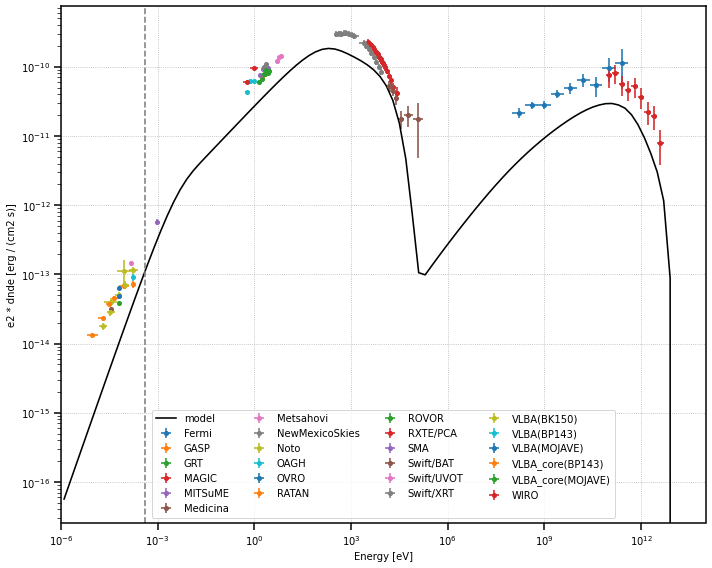

In [10]:
load_mpl_rc()
fig, ax = plt.subplots(figsize=(10, 8))

for key in flux_points.keys():
    flux_points[key].plot(ax=ax, label=key)

model.spectral_model.plot(
    energy_bounds=[1e-6, 1e14] * u.eV, energy_power=2, label="model", color="k", lw=1.6,
)

# plot a line marking the minimum energy considered in the fit
ax.axvline(E_min_fit, ls="--", color="gray")

plt.legend(ncol=4)
plt.xlim([1e-6, 1e14])
plt.show()

#### 4) run the fit

In [ ]:
%%time
# define the fitter
fitter = Fit()
results = fitter.run(datasets)

In [ ]:
print(results)
print(model.spectral_model.parameters.to_table())

Now let us plot the final model and the flux points

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

for key in flux_points.keys():
    flux_points[key].plot(ax=ax, label=key)

model.spectral_model.plot(
    energy_bounds=[1e-6, 1e14] * u.eV, energy_power=2, label="model", color="k", lw=1.6
)

# plot a line marking the minimum energy considered in the fit
ax.axvline(E_min_fit, ls="--", color="gray")

plt.legend(ncol=4)
plt.xlim([1e-6, 1e14])
plt.show()